# Notebook

In [50]:
#%matplotlib qt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# import the ZPs
from mtflearn import ZPs

## Step 1: create a ZPs object

`n_max`: the maximum radial index for the set of Zernike polynomials

`size`: the patch size to represent each Zernike polynomial

In [51]:
n_max = 10
size = 128
zps = ZPs(n_max=10, size=size)

# zps_data is a 3D numpy array with a shape of (N, size, size), where N is the total number of Zernike polynomial, if n_max = 10, N = 66
zps_data = zps.polynomials
print(zps_data.shape)

(66, 128, 128)


## Step 2: visualize the Zernike polynomials

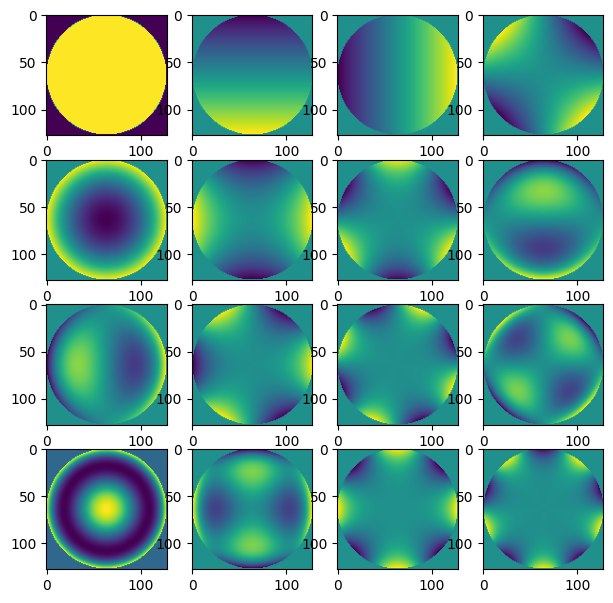

In [52]:
# plot the first 16 Zernike polynomials

fig, axes = plt.subplots(4, 4, figsize=(7.2, 7.2))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(zps_data[i])

## Step 3: preparing your own data

In [53]:
import numpy as np
from skimage.transform import rotate
from skimage.util import random_noise

def rotation_matrix(angle):
    angle = np.radians(angle)
    s = np.sin(angle)
    c = np.cos(angle)
    R = np.array([(c, -s), (s, c)])
    return process_zeros(R)


def process_zeros(data, eps=1e-9):
    data[np.abs(data) < eps] = 0.0
    return data


def rotate_pts(pts, angle):
    pts = np.array(pts)
    R = rotation_matrix(angle)
    return np.dot(pts, R)


def many_gaussians(pts, sigma, s):
    data = np.zeros((s, s))
    Y, X = np.ogrid[-s // 2:s // 2:1j * s, -s // 2:s // 2:1j * s]
    for (x, y) in pts:
        data = data + np.exp((-(X - x) ** 2 - (Y - y) ** 2) / (2 * sigma * sigma))
    return data

def gn(n, size=128, sigma=None, l=None, theta=0, include_center=True, A=0.9):
    if sigma is None:
        sigma = size / 20
    if l is None:
        l = size * 0.25
    else:
        l = size * l
    p0 = np.array([0, l])
    p0 = rotate_pts(p0, theta)
    pts = np.array([rotate_pts(p0, 360 * i / n) for i in range(n)])
    if include_center:
        gs = many_gaussians(pts, sigma, size) + A * many_gaussians([(0, 0)], sigma, size)
    else:
        gs = many_gaussians(pts, sigma, size)

    return gs


def make_rot_data(N, n=3, size=128, sigma=None, l=None, theta=0, include_center=True, A=0.9):
    img = gn(n, size, sigma, l, theta, include_center, A)

    angles = np.linspace(0, 360, N)
    ps = np.array([rotate(img, angle) for angle in angles])
    return ps


(300, 128, 128)


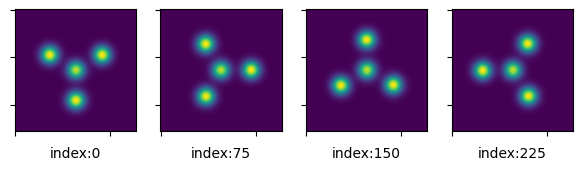

In [54]:
# we generate a total number of 300 patches with a shape of (128, 128)
num = 300
ps = make_rot_data(N=num)
print(ps.shape)

# only show a few
fig, axes = plt.subplots(1, 4, figsize=(7.2, 7.2))
for i, ax in enumerate(axes.ravel()):
    j = int(num//4*i)
    ax.imshow(ps[j])
    ax.set_xlabel('index:{}'.format(j))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

## Step 4: extract Zernike features from your own data

In [55]:
# we have `zps` and our data is `ps`, follow the sckit-learn API, we use `fit_transform()`
m = zps.fit_transform(ps)
# m is a zmoments object
print(m)
# m.data is a numpy array
print(m.data.shape)

(300, 66)


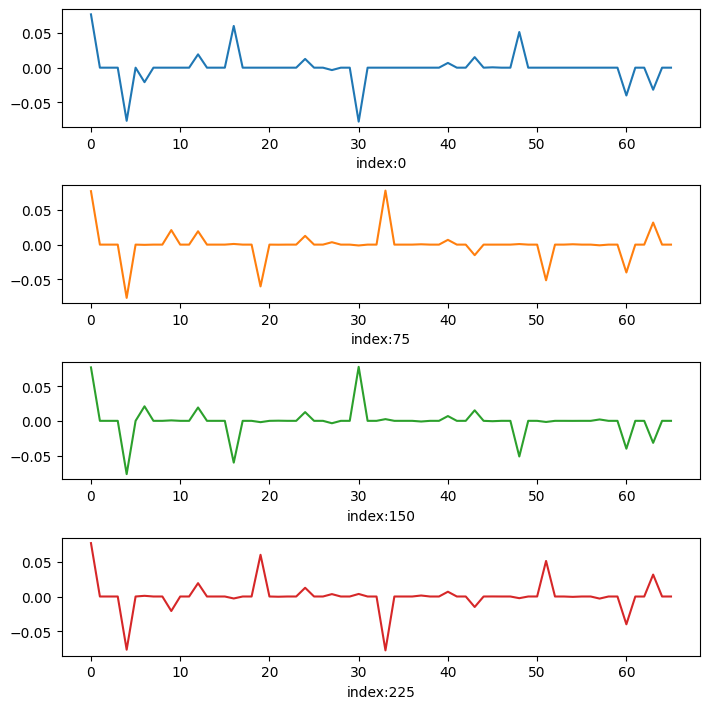

In [56]:
# visualize the full Zernike features, notice that they are different since rotation invariant is now off!
fig, axes = plt.subplots(4, 1, figsize=(7.2, 7.2))
for i, ax in enumerate(axes.ravel()):
    j = int(num//4*i)
    ax.plot(m.data[j], color='C{}'.format(i))
    ax.set_xlabel('index:{}'.format(j))
fig.tight_layout()

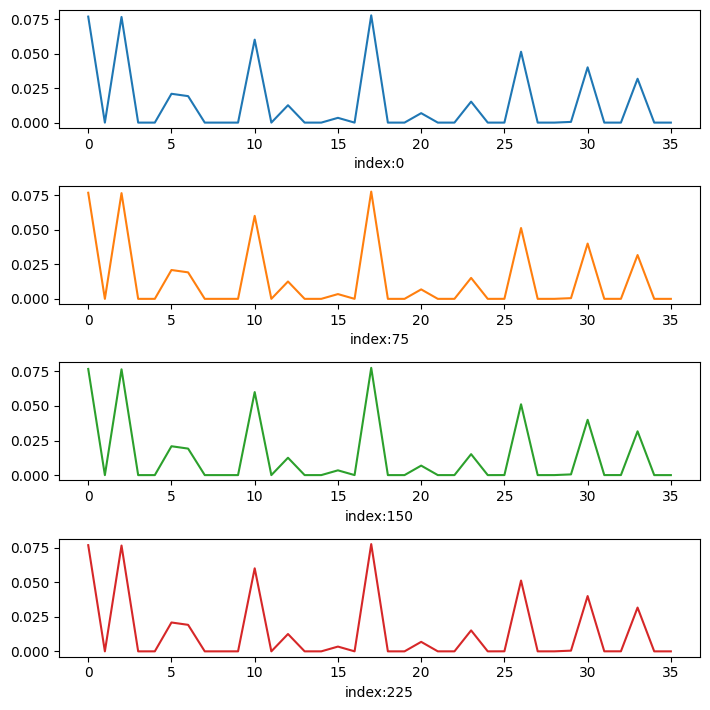

In [57]:
# X is now rotational invariant
X = np.abs(m.to_complex().data)

# visualize the Zernike features, notice that they are the same since we are plotting the rotationally invariant part!
fig, axes = plt.subplots(4, 1, figsize=(7.2, 7.2))
for i, ax in enumerate(axes.ravel()):
    j = int(num//4*i)
    ax.plot(X[j], color='C{}'.format(i))
    ax.set_xlabel('index:{}'.format(j))
fig.tight_layout()